# Crear Web API para utilizar modelos entrenados de StarWars con TensorFlow+Keras usando Flask y ngrok
Fuentes:

https://blog.keras.io/building-a-simple-keras-deep-learning-rest-api.html

https://deeplizard.com/learn/video/SI1hVGvbbZ4

https://curiousily.com/posts/deploy-keras-deep-learning-project-to-production-with-flask/

https://pyngrok.readthedocs.io/en/latest/integrations.html#google-colaboratory

# Cargar Modelos ya entrenados

In [1]:
#@title Accede al Drive

# Acceder al drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
#@title Cargar Modelo para Datos ya entrenado con sus complementos
import os
import joblib
import tensorflow
from tensorflow.keras.models import load_model

cargar_modelo_datos = True #@param {type:"boolean"}
path_modelo_datos = '/content/gdrive/MyDrive/IA/demoStarWars/modelos/datosMLP'  #@param {type:"string"}

datos_model = None
if cargar_modelo_datos:
    # cargar modelo
    datos_model = load_model(path_modelo_datos)
    print("\n* Modelo cargado de ", path_modelo_datos, "\n")
    datos_model.summary()

    # cargar scaler (si existe)
    fn_scaler = path_modelo_datos+"/scaler.joblib"
    if os.path.isfile(fn_scaler):
      datos_scaler = joblib.load(fn_scaler)
      print("\n* Scaler cargado de ", fn_scaler, "\n")
    else:
      datos_scaler = None
      print("\n* Scaler no encontrado en ", fn_scaler, "\n")

    fn_clases = path_modelo_datos +"/CLASES_MAP.txt"
    datos_CLASES = []
    if os.path.isfile(fn_clases):
      with open(fn_clases, 'r') as f:
        # carga datos
        auxData = f.readlines()
      for c in auxData:
        id, desc = c.replace("\n", "").split(":")
        datos_CLASES.append(desc)
      print("\n* CLASES definidas cargado de ", fn_clases, ":")
      print("\t\t", datos_CLASES, "\n")
    else:
      print("\n* CLASES no encontradas en ", fn_clases, "\n")



* Modelo cargado de  /content/gdrive/MyDrive/IA/demoStarWars/modelos/datosMLP 

Model: "RNA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 74)]              0         
                                                                 
 hidd_1 (Dense)              (None, 48)                3600      
                                                                 
 hidd_2 (Dense)              (None, 24)                1176      
                                                                 
 output (Dense)              (None, 12)                300       
                                                                 
Total params: 5076 (19.83 KB)
Trainable params: 5076 (19.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

* Scaler no encontrado en  /content/gdrive/MyDrive/IA/demoStarWars/modelos/dato

In [3]:
#@title Cargar Modelo para Imágenes ya entrenado con sus complementos
import os
import joblib
import tensorflow
from tensorflow.keras.models import load_model

cargar_modelo_imagenes = True #@param {type:"boolean"}
path_modelo_imagenes = '/content/gdrive/MyDrive/IA/demoStarWars/modelos/ImagMLP'  #@param {type:"string"}

from PIL import Image
from keras.preprocessing.image import img_to_array

def prepare_image(image):
  global IMAGE_SHAPE
  # ajusta el tamaño
  if IMAGE_SHAPE[2]==1:
    tipoImage = 'L'
  else:
    tipoImage = 'RGB'
  imag = image.convert(tipoImage)
  # resize the input image and preprocess it
  imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)
  imag = img_to_array(imag)
  imag = np.expand_dims(imag, axis=0)
  # return the processed image
  return imag

img_model = None
if cargar_modelo_imagenes:
    # cargar modelo
    img_model = load_model(path_modelo_imagenes)
    print("\n* Modelo cargado de ", path_modelo_imagenes, "\n")
    img_model.summary()

    fn_imageShape = path_modelo_imagenes+"/IMAGE_SHAPE.txt"
    IMAGE_SHAPE = []
    if os.path.isfile(fn_imageShape):
      with open(fn_imageShape, 'r') as f:
        # carga datos
        auxData = f.readlines()
      for c in auxData:
        IMAGE_SHAPE.append( int(c.replace("\n", "")) )
      print("\n* IMAGE_SHAPE definido cargado de ", fn_imageShape, ":")
    else:
      # intenta toma input shape del modleo
      try:
        IMAGE_SHAPE = list(img_model.layers[0].output_shape[0][1:])
      except :
        IMAGE_SHAPE = [32, 32, 3] # valor por defecto
      print("\n* IMAGE_SHAPE no encontrado en ", fn_imageShape, " -> se usa valor por defecto:")
    print("\t\t", IMAGE_SHAPE, "\n")


    fn_clases = path_modelo_imagenes+"/CLASES_MAP.txt"
    img_CLASES = []
    if os.path.isfile(fn_clases):
      with open(fn_clases, 'r') as f:
        # carga datos
        auxData = f.readlines()
      for c in auxData:
        id, desc = c.replace("\n", "").split(":")
        img_CLASES.append(desc)
      print("\n* CLASES definidas cargado de ", fn_clases, ":")
      print("\t\t", img_CLASES, "\n")
    else:
      print("\n* CLASES no encontradas en ", fn_clases, "\n")



* Modelo cargado de  /content/gdrive/MyDrive/IA/demoStarWars/modelos/ImagMLP 

Model: "RNA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 slng_1/255 (Rescaling)      (None, 32, 32, 3)         0         
                                                                 
 flat (Flatten)              (None, 3072)              0         
                                                                 
 hidd_1 (Dense)              (None, 520)               1597960   
                                                                 
 hidd_2 (Dense)              (None, 128)               66688     
                                                                 
 hidd_3 (Dense)              (None, 64)                8256      
                                                 

# Preparar Web API

In [4]:
#@title Instalar pyngrok (opcional)

usar_ngrok_web_publica = True #@param{type:"boolean"}

if usar_ngrok_web_publica:
  # Instalar pyngrok
  !pip install pyngrok
  print("")
else:
  print("- no se usa ngrok.")


In [5]:
#@title Preparar la conexión con ngrok para hacer sitio público (opcional)

ngrok_auth_token = "" #@param {type:"string"}

if usar_ngrok_web_publica:
  import getpass
  from pyngrok import ngrok, conf

  # determina el authentication token de ngrok (
  if (ngrok_auth_token == ""):
    print("Ingrese el authtoken indicada en https://dashboard.ngrok.com/get-started/your-authtoken luego de registrarse")
    conf.get_default().auth_token = getpass.getpass()
  else:
    conf.get_default().auth_token = ngrok_auth_token
  print("")
  # Open a TCP ngrok tunnel to the SSH server
  connection_string = ngrok.connect("22", "tcp").public_url
  print("")
  ssh_url, port = connection_string.strip("tcp://").split(":")
  print("")
  print(f" * se crea ngrok tunnel, accediendo con `ssh root@{ssh_url} -p{port}`")
else:
  print("- no se usa ngrok.")


Ingrese el authtoken indicada en https://dashboard.ngrok.com/get-started/your-authtoken luego de registrarse
··········



 * se crea ngrok tunnel, accediendo con `ssh root@0.tcp.ngrok.io -p18017`


In [6]:
#@title Habilitar Web API con Flash

import threading
import pandas as pd
import io
from flask import Flask, jsonify, request, current_app
import numpy as np
import logging
import uuid
import os


# controla que se haya cargado al menos un modelo
if (datos_model is None) and (img_model is None):
  raise Exception("No existen modelo cargados para usar!!!")

# crea la application
app = Flask(__name__)

# define parámetros
local_port = "5000" #@param {type:"string"}
nombre_servicio_datos = "/SWdatos" #@param {type:"string"}
nombre_servicio_imagenes = "/SWimagen" #@param {type:"string"}

# define url local del servicio
urlLocal = "http://127.0.0.1:{}".format(local_port)

print("")
if usar_ngrok_web_publica:
  # Open a ngrok tunnel to the HTTP server

  public_url = ngrok.connect(local_port).public_url
  print(" * ngrok tunnel definido: \"{}\" <-> \"{}\"".format(public_url, urlLocal))

  # Update any base URLs to use the public ngrok URL
  app.config["BASE_URL"] = public_url
  # ... Update inbound traffic via APIs to use the public-facing ngrok URL
  ngrok_public_Web_API_DATOS = public_url + nombre_servicio_datos
  ngrok_public_Web_API_IMAGENES = public_url + nombre_servicio_imagenes
  ngrok_public_Web_PAGE = public_url + "/"
else:
  ngrok_public_Web_API_DATOS = ""
  ngrok_public_Web_API_IMAGENES = ""
  ngrok_public_Web_PAGE = None
  print("- no se usa ngrok.")

# configura logging en archivo
logFileName = "/content/modelWebAPI.log"
logger = logging.getLogger(__name__)
file_handel = logging.FileHandler(logFileName)
file_handel.setFormatter(logging.Formatter('%(asctime)s %(levelname)s - %(message)s'))
file_handel.setLevel(logging.DEBUG)
logger.addHandler(file_handel)

# funciones auxiliares
def mostrarLog():
  stream = os.popen("cat '"+ logFileName +"'")
  output = stream.read()
  print(output)

def devolverOK(claseID, claseDesc=""):
 data = {"claseID": claseID, "clase": claseDesc}
 current_app.logger.debug("+ devuelveOK=" + str(data))
 return jsonify(statusCode=200, message= "Success",
                  data=data)

def devolverError(msgError, data=None):
    current_app.logger.debug("- devuelveError=" + msgError)
    return jsonify(statusCode=500, message=msgError,
                   data=data)

# confirma que el modelo de datos se cargo
if datos_model is None:
  ngrok_public_Web_API_DATOS = ""
else:
  # define el servicio para clasificar flores IRIS
  @app.route(nombre_servicio_datos, methods=["POST"])
  def datos_model_web_api():
    try:
      current_app.logger.debug("+ conexion recibida: " + str(uuid.uuid4()))
      # recibe datos de conexion
      if request.method != "POST":
        return devolverError("METHOD NO POST!")
      data = request.json
      current_app.logger.debug("- datos recibidos: " + str(data))
      # formatea datos como números
      valsInput = np.array( pd.DataFrame(data, index=[0]), dtype=np.float32)
      current_app.logger.debug("- datos convertidos: " + str(valsInput))
      # si está definido el scaler normaliza los datos
      if datos_scaler is not None:
        valsInput = datos_scaler.transform(valsInput)
        current_app.logger.debug("- datos normalizados: " + str(valsInput))
      # ejecuta el modelo con los datos convertidos/normalizados
      resModel = datos_model.predict(valsInput, verbose=0)
      current_app.logger.debug("- resultado del modelo: " + str(resModel))
      # se genera un resultado
      if (len(resModel) == 1):
          # identifica tipo de salida
          if (len(resModel[0]) == 1):
              # como tiene una salida se asume salida lineal (solo la redondea)
              claseID = round(resModel[0])
          else:
              # como tiene validas salidas se asume salida softmax (toma la de mayor puntaje)
              claseID = int( np.argmax(resModel[0], axis=0) )
          current_app.logger.debug("* clase asignada por modelo: " + str(claseID))
          # determina la descripción de la clase
          if (datos_CLASES is not None) and (len(datos_CLASES)>0) and (claseID<len(datos_CLASES)):
            claseDesc = datos_CLASES[claseID]
          else:
            claseDesc = str(claseID)
          # devuelve OK
          return devolverOK(claseID, claseDesc)
      else:
          # no se genera un único resultado (error)
          return devolverError("resultado del modelo distino de un elemento",
                                  data={"resModel": resModel})
    except Exception as error:
      return devolverError("error detectado: " + str(error))

  # muestra nombre de APIs
  nombre_WebAPI_datos = "{}{}".format(urlLocal, nombre_servicio_datos)
  print("\n > Web API local para Datos establecida en: ",  nombre_WebAPI_datos)
  if usar_ngrok_web_publica and (ngrok_public_Web_API_DATOS is not None):
    print("\n > ngrok public Web API para Datos establecida en: ",  ngrok_public_Web_API_DATOS)


# confirma que el modelo de imágenes se cargo
if img_model is None:
  ngrok_public_Web_API_IMAGENES = ""
else:
  # define el servicio para clasificar flores IRIS
  @app.route(nombre_servicio_imagenes, methods=["POST"])
  def imag_model_web_api():
    try:
      current_app.logger.debug("+ conexion recibida: " + str(uuid.uuid4()))
      if request.method != "POST":
        return devolverError("METHOD NO POST!")
      if request.files.get("image"):
        # read the image in PIL format
        image = request.files["image"].read()
        image = Image.open(io.BytesIO(image))
        # preprocess the image and prepare it for classification
        imagePrep = prepare_image(image)
        current_app.logger.debug("- imagen preparada")
        # ejecuta el modelo con la imagen preparada
        resModel = img_model.predict(imagePrep, verbose=0)
        current_app.logger.debug("- resultado del modelo: " + str(resModel))
        # se genera un resultado
        if (len(resModel) == 1):
            # identifica tipo de salida
            if (len(resModel[0]) == 1):
                # como tiene una salida se asume salida lineal (solo la redondea)
                claseID = round(resModel[0])
            else:
                # como tiene validas salidas se asume salida softmax (toma la de mayor puntaje)
                claseID = int( np.argmax(resModel[0], axis=0) )
            current_app.logger.debug("* clase asignada por modelo: " + str(claseID))
            # determina la descripción de la clase
            if (img_CLASES is not None) and (len(img_CLASES)>0) and (claseID<len(img_CLASES)):
              claseDesc = img_CLASES[claseID]
            else:
              claseDesc = str(claseID)
            # devuelve OK
            return devolverOK(claseID, claseDesc)
        else:
            # no se genera un único resultado (error)
            return devolverError("resultado del modelo distino de un elemento",
                                  data={"resModel": resModel})
      else:
        return devolverError("no se puede recuperar imagen enviada!")
    except Exception as error:
      return devolverError("error detectado: " + str(error))

  # muestra nombre de APIs
  nombre_WebAPI_imagenes = "{}{}".format(urlLocal, nombre_servicio_imagenes)
  print("\n > Web API local para Imágenes establecida en: ",  nombre_WebAPI_imagenes)
  if usar_ngrok_web_publica and (ngrok_public_Web_API_IMAGENES is not None):
    print("\n > ngrok public Web API para Imágenes establecida en: ",  ngrok_public_Web_API_IMAGENES)

# Start the Flask server in a new thread
threading.Thread(target=app.run, kwargs={"use_reloader": False, "port" : local_port, "debug": True}).start()

# espera 5 segundos a que arranque el servicio
import time
time.sleep(5)


 * ngrok tunnel definido: "https://cbbc-34-85-166-144.ngrok-free.app" <-> "http://127.0.0.1:5000"

 > Web API local para Datos establecida en:  http://127.0.0.1:5000/SWdatos

 > ngrok public Web API para Datos establecida en:  https://cbbc-34-85-166-144.ngrok-free.app/SWdatos

 > Web API local para Imágenes establecida en:  http://127.0.0.1:5000/SWimagen

 > ngrok public Web API para Imágenes establecida en:  https://cbbc-34-85-166-144.ngrok-free.app/SWimagen
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


# Probar Web API local

In [7]:
#@title Probar Web API local para Datos con un ejemplo tomado al azar del drive

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random
import os
import csv

import json
import requests

# función auxiliar para probar API
def ejecutarModelWebAPI_datos(dictValues, URL_API, mostrarRes=True):
  # ejecuta la web API usando request
  headers = {"content-type": "application/json",
             "ngrok-skip-browser-warning": "69420" }
  data_json = json.dumps( dictValues )
  json_response = requests.post(URL_API, data=data_json, headers=headers)
  if json_response.status_code == 200:
    res = json.loads(json_response.text)
    if mostrarRes:
      print("\t", json_response, "-", res)
    return res["data"]
  else:
    if mostrarRes:
      print("\t", json_response, ":", json_response.content)
    return "ERROR"

#@markdown ### Archivo de datos a utilizar:
path = '/content/gdrive/MyDrive/IA/demoStarWars/datos/'  #@param {type:"string"}
archivo_datos = 'naves.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global ndf
  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return
  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    ##print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )
  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return
  # selecciona un ejemplo al azar
  ndf = df.sample()
  # genera los datos solo con los atributos seleccionados
  datosEntrada = ndf[att_entrada].to_dict(orient='records')
  datosClase = ndf[attClase]
  print("\n> Datos enviados: ", datosEntrada)
  print("> Clase Real: ",datosClase)
  # ejecuta API
  res = ejecutarModelWebAPI_datos(datosEntrada,
                                    nombre_WebAPI_datos)
  print("\n> Resultado API: ",  res)
  print("")

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Enviar al azar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases,
                combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  naves.csv  cargado


GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…

DEBUG:__main__:+ conexion recibida: 6092b2ac-19cd-4ea9-8c9b-340e02405073
DEBUG:__main__:- datos recibidos: [{'Manufacturer': 8.0, 'Length': 501.0, 'Crew': 3505.0, 'Cargo Capacity': 500000.0, 'Consumables': 9.0, 'Hyperdrive Multiplier': 1.0, 'Hyperdrive Backup': 12.0, 'Speed': 12.0, 'Hull': 912.0, 'Shields': 1600.0, 'Troops': 800.0, 'Onboard Craft': 0.9959861544792896, 'Special Features': 1.0, 'DOUBLE TURBOLASER CANNONS': 0.0, 'QUAD LASER CANNONS': 0.0, 'CONCUSSION MISSILE LAUNCHERS': 0.0, 'LASER CANNONS': 0.0, 'PROTON TORPEDOS': 0.0, 'ORBITAL MINE OR THERMAL DETONATOR LAUNCHER.': 0.0, 'ION CANNON BATTERIES': 0.0, 'GENERAL PURPOSE LAUNCHERS': 0.0, 'HEAVY TURBOLASER BATTERIES': 0.0, 'HEAVY LASER CANNONS': 0.0, 'ION CANNONS': 0.0, 'TRACTOR BEAM PROJECTORS': 0.0, 'GRAVITY WELL PROJECTORS': 0.0, 'SUPERLASERS': 0.0, 'DOUBLE BLASTER CANNON TURRETS': 0.0, 'DOUBLE BLASTER CANNONS': 0.0, 'DOUBLE LASER CANNONS': 0.0, 'TWIN LASER CANNONS': 10.0, 'LASER CANNON TURRETS': 0.0, 'BUILD-IN SPACE BOMB.':



> Datos enviados:  [{'Manufacturer': 8.0, 'Length': 501.0, 'Crew': 3505.0, 'Cargo Capacity': 500000.0, 'Consumables': 9.0, 'Hyperdrive Multiplier': 1.0, 'Hyperdrive Backup': 12.0, 'Speed': 12.0, 'Hull': 912.0, 'Shields': 1600.0, 'Troops': 800.0, 'Onboard Craft': 0.9959861544792896, 'Special Features': 1.0, 'DOUBLE TURBOLASER CANNONS': 0.0, 'QUAD LASER CANNONS': 0.0, 'CONCUSSION MISSILE LAUNCHERS': 0.0, 'LASER CANNONS': 0.0, 'PROTON TORPEDOS': 0.0, 'ORBITAL MINE OR THERMAL DETONATOR LAUNCHER.': 0.0, 'ION CANNON BATTERIES': 0.0, 'GENERAL PURPOSE LAUNCHERS': 0.0, 'HEAVY TURBOLASER BATTERIES': 0.0, 'HEAVY LASER CANNONS': 0.0, 'ION CANNONS': 0.0, 'TRACTOR BEAM PROJECTORS': 0.0, 'GRAVITY WELL PROJECTORS': 0.0, 'SUPERLASERS': 0.0, 'DOUBLE BLASTER CANNON TURRETS': 0.0, 'DOUBLE BLASTER CANNONS': 0.0, 'DOUBLE LASER CANNONS': 0.0, 'TWIN LASER CANNONS': 10.0, 'LASER CANNON TURRETS': 0.0, 'BUILD-IN SPACE BOMB.': 0.0, 'TURBOLASER CANNONS': 0.0, 'TURBOLASER BATTERIES': 0.0, 'DOUBLE HEAVY LASER TURR

DEBUG:__main__:- resultado del modelo: [[3.09354030e-02 2.19497401e-02 3.56632681e-03 1.12645875e-03
  6.88727438e-01 4.91216918e-03 1.82736933e-03 4.09222720e-03
  6.28121123e-02 1.79900527e-01 1.18344715e-05 1.38339397e-04]]
DEBUG:__main__:* clase asignada por modelo: 4
DEBUG:__main__:+ devuelveOK={'claseID': 4, 'clase': 'Other Starfighters'}
INFO:werkzeug:127.0.0.1 - - [26/Feb/2024 22:16:28] "POST /SWdatos HTTP/1.1" 200 -


	 <Response [200]> - {'data': {'clase': 'Other Starfighters', 'claseID': 4}, 'message': 'Success', 'statusCode': 200}

> Resultado API:  {'clase': 'Other Starfighters', 'claseID': 4}



GridBox(children=(Text(value='/content/gdrive/MyDrive/IA/demoStarWars/imagenes', description='Path imágenes:',…



> Imagen:  /content/gdrive/MyDrive/IA/demoStarWars/imagenes/test/Landing Craft/e0a2cc5ed8ad4f2b991717506fe8e4d3.png


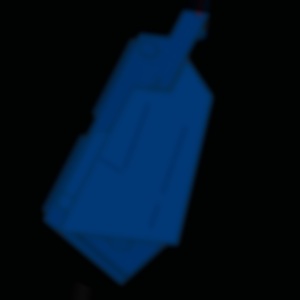

DEBUG:__main__:+ conexion recibida: bb8abe82-9b8f-453d-9af3-ea2ce1d4f9ef
DEBUG:__main__:- imagen preparada
DEBUG:__main__:- resultado del modelo: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0109996e-32 0.0000000e+00
  3.6362014e-37 1.0000000e+00 0.0000000e+00 2.9397084e-33 0.0000000e+00
  2.1442905e-32 0.0000000e+00]]
DEBUG:__main__:* clase asignada por modelo: 6
DEBUG:__main__:+ devuelveOK={'claseID': 6, 'clase': 'Landing Craft'}
INFO:werkzeug:127.0.0.1 - - [26/Feb/2024 22:16:30] "POST /SWimagen HTTP/1.1" 200 -


	 <Response [200]> - {'data': {'clase': 'Landing Craft', 'claseID': 6}, 'message': 'Success', 'statusCode': 200}

> Resultado API:  {'clase': 'Landing Craft', 'claseID': 6}



In [8]:
#@title Probar Web API local para Imágenes con un ejemplo tomado al azar del drive

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random

import json
import requests

# función auxiliar para probar API
def ejecutarModelWebAPI_imagenes(imageFN, URL_API, mostrarRes=True):
  # prepara la info de la imagen a mandar como archivo
  dictValues = {'image': (os.path.basename(imageFN),
                          open(imageFN, "rb").read(),
                          #'multipart/form-data',
                           {'Expires': '0'}) }
  # ejecuta la web API
    # ejecuta la web API usando request
  headers = {"ngrok-skip-browser-warning": "69420" }
  json_response = requests.post(URL_API, files=dictValues, headers=headers)
  if json_response.status_code == 200:
    res = json.loads(json_response.text)
    if mostrarRes:
      print("\t", json_response, "-", res)
    return res["data"]
  else:
    if mostrarRes:
      print("\t", json_response, ":", json_response.content)
    return "ERROR"

def procesarImagen(imageFN):
  print("\n> Imagen: ", imageFN)
  display( Image.open(imageFN) )
  # ejecuta API
  res = ejecutarModelWebAPI_imagenes(imageFN,
                                    nombre_WebAPI_imagenes)
  print("\n> Resultado API: ",  res)
  print("")
  return res

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  # determina directorio y elege un archivo al azar
  class_path = path_imagenes.value + "/" + path_imagenes_tipo.value + "/" + combo_clase.value
  images_in_class_path = os.listdir( class_path )
  imageFN = random.choice(images_in_class_path)
  procesarImagen(class_path + "/" + imageFN)

# permite seleccionar una clase y toma una imagen al azar
path_imagenes = widgets.Text(
    value='/content/gdrive/MyDrive/IA/demoStarWars/imagenes',
    description='Path imágenes:',
    disabled=False,
    style= {'description_width': 'initial', 'width': 'initial'},
    layout = widgets.Layout(width='500px')
)
path_imagenes_tipo = widgets.Dropdown(
    options = ["train", "test"],
    value = "test",
    description = "Tipo path imágenes:",
    disabled = False,
    style= {'description_width': 'initial', 'width': 'initial'}
)
all_image_classes = os.listdir( path_imagenes.value + "/" + path_imagenes_tipo.value )
combo_clase = widgets.Dropdown(
    options = all_image_classes,
    description = 'Clase a procesar:',
    disabled = False,
    style= {'description_width': 'initial', 'width': 'initial'}
)
# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Ejecutar'
)
configDatos_ui = widgets.GridBox(
      children=[path_imagenes, path_imagenes_tipo, combo_clase, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

on_buttonAplicar_clicked(btnAplicar)

In [11]:
#@title Mostrar Archivo de Log
print("")
mostrarLog()
print("")


2024-02-26 22:16:27,742 DEBUG - + conexion recibida: 6092b2ac-19cd-4ea9-8c9b-340e02405073
2024-02-26 22:16:27,749 DEBUG - - datos recibidos: [{'Manufacturer': 8.0, 'Length': 501.0, 'Crew': 3505.0, 'Cargo Capacity': 500000.0, 'Consumables': 9.0, 'Hyperdrive Multiplier': 1.0, 'Hyperdrive Backup': 12.0, 'Speed': 12.0, 'Hull': 912.0, 'Shields': 1600.0, 'Troops': 800.0, 'Onboard Craft': 0.9959861544792896, 'Special Features': 1.0, 'DOUBLE TURBOLASER CANNONS': 0.0, 'QUAD LASER CANNONS': 0.0, 'CONCUSSION MISSILE LAUNCHERS': 0.0, 'LASER CANNONS': 0.0, 'PROTON TORPEDOS': 0.0, 'ORBITAL MINE OR THERMAL DETONATOR LAUNCHER.': 0.0, 'ION CANNON BATTERIES': 0.0, 'GENERAL PURPOSE LAUNCHERS': 0.0, 'HEAVY TURBOLASER BATTERIES': 0.0, 'HEAVY LASER CANNONS': 0.0, 'ION CANNONS': 0.0, 'TRACTOR BEAM PROJECTORS': 0.0, 'GRAVITY WELL PROJECTORS': 0.0, 'SUPERLASERS': 0.0, 'DOUBLE BLASTER CANNON TURRETS': 0.0, 'DOUBLE BLASTER CANNONS': 0.0, 'DOUBLE LASER CANNONS': 0.0, 'TWIN LASER CANNONS': 10.0, 'LASER CANNON TUR